# Preprocessing

## Installations

In [ ]:
!pip install transformers
!pip install --upgrade transformers
!pip install datasets
!pip install threadpoolctl
!pip install evaluate
!pip install rouge_score
!pip install pycocoevalcap
!pip install transformers
!pip install sentencepiece

In [ ]:
import os
import tqdm
import json
import random

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import Image
import pandas as pd

import torch
import numpy as np

from xml.dom import minidom

from pathlib import Path
from google.colab import drive

import nltk
import evaluate

from datasets import Dataset, DatasetDict

from transformers import ViTImageProcessor, BioGptTokenizer, TrainingArguments, Trainer
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
from transformers import pipeline
from transformers import default_data_collator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers.utils import logging

from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

## Set-Up Torch Device and Working Directory

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

drive.mount('/content/gdrive')
%cd "gdrive"
%cd "MyDrive"
%cd "RESEARCH - Radiological Report Generation (Troy)"

## Read the X-Ray Dataset

In [3]:
# Go to directory of dataset
files = os.listdir('RESEARCH - NLMCXR Dataset/ecgen-radiology')
data = pd.DataFrame(columns=['image_path', 'caption'])

for file in tqdm.tqdm(files):
    # For each file in the directory:
    file = minidom.parse(f'RESEARCH - NLMCXR Dataset/ecgen-radiology/{file}')
    num_views = len(file.getElementsByTagName('url'))
    for j in range(num_views):
        image_path = file.getElementsByTagName('url')[j].firstChild.nodeValue
        
        # Exclude lateral X-ray reports
        if '2001' in image_path:
            continue
            
        image_path = image_path.replace('/hadoop/storage/radiology/extract/', '')
        image_path = image_path.replace('.jpg', '.png')
        
        abstract = file.getElementsByTagName('AbstractText')
        if abstract[-1].firstChild and abstract[-2].firstChild:
            # Minimal parsing for dataset that will be processed by computer
            impression = abstract[-1].firstChild.nodeValue
            findings = abstract[-2].firstChild.nodeValue
            report_text = f'FINDINGS:\n{findings}\nIMPRESSION:\n{impression}'
            data.loc[len(data)] = ['RESEARCH - NLMCXR Dataset/NLMCXR_png/' + image_path, report_text]

data = data[data['caption'].apply(len) < 400].reset_index(drop=True)
data = data.drop_duplicates('caption').reset_index(drop=True)

100%|██████████| 3955/3955 [01:00<00:00, 65.67it/s] 

                                             image_path  \
0     RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR3682_I...   
1     RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR3699_I...   
2     RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR3691_I...   
3     RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR3690_I...   
4     RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR3692_I...   
...                                                 ...   
1958  RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR1873_I...   
1959  RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR1844_I...   
1960  RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR1887_I...   
1961  RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR1886_I...   
1962  RESEARCH - NLMCXR Dataset/NLMCXR_png/CXR1849_I...   

                                                caption  
0     FINDINGS:\nThe lungs are hypoventilated. There...  
1     FINDINGS:\nNormal heart size mediastinal conto...  
2     FINDINGS:\nThe heart is normal in size. The me...  
3     FINDINGS:\nThe heart is again enlarged. Aorta ...  
4

## Preparation of Tokenizers, Model and Feature Extractors

<AxesSubplot:>

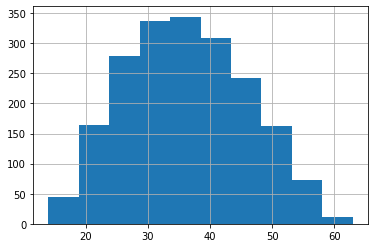

In [4]:
def word_count(str):
    words = str.split()
    return len(words)
data['caption'].apply(word_count).hist()

In [5]:
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.1.crossattention.masked_bias', 'h.7.crossattention.bias', 'h.8.ln_cross_attn.weight', 'h.3.crossattention.bias', 'h.0.ln_cross_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.4.ln_cross_attn.weight', 'h.2.crossattention.c_attn.weight', 'h.9.crossattention.c_proj.bias', 'h.1.crossattention.q_attn.weight', 'h.10.crossattention.c_proj.weight', 'h.0.crossattention.masked_bias', 'h.3.crossattention.q_attn.weight', 'h.10.crossattention.masked_bias', 'h.3.crossattention.masked_bias', 'h.11.crossattention.masked_bias', 'h.11.crossattention.q_attn.weight', 'h.9.crossattention.bias', 'h.3.crossattention.c_attn.weight', 'h.3.crossattention.c_proj.bias', 'h.5.crossattention.q_attn.weight', 'h.4.crossattention.q_attn.weight', 'h.0.crossattention.c_attn.weight', 'h.1.crossattention.c_attn.weight', 'h.7.ln_cross_attn.weight', 'h.0.crossattention.c_proj.weight', 'h.6.crossattention

In [6]:
feature_extractor = ViTImageProcessor.from_pretrained(image_encoder_model)
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

In [7]:
# # GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.unk_token

# # update the model config
model.eos_token_id = tokenizer.eos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

model.decoder_start_token_id = tokenizer.bos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id

model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

model.max_length = 128
model.config.max_length = 128
model.config.decoder.max_length = 128

model.min_length = 40
model.config.min_length = 40
model.config.decoder.min_length = 40

model.no_repeat_ngram_size = 3
model.config.no_repeat_ngram_size = 3
model.config.decoder.no_repeat_ngram_size = 3


tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [8]:
# output_dir = "vit-gpt-model"
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('vit-gpt-model/tokenizer_config.json',
 'vit-gpt-model/special_tokens_map.json',
 'vit-gpt-model/vocab.json',
 'vit-gpt-model/merges.txt',
 'vit-gpt-model/added_tokens.json',
 'vit-gpt-model/tokenizer.json')

## Final processing of dataset

In [9]:
train_dataset = Dataset.from_pandas(data[:654])
validation_dataset = Dataset.from_pandas(data[654:1308])
test_dataset = Dataset.from_pandas(data[1308:])

In [10]:
ds = DatasetDict()

ds['train'] = train_dataset
ds['validation'] = validation_dataset
ds['test'] = test_dataset

In [11]:
from PIL import Image

# text preprocessing step
def tokenization_fn(captions, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(captions, 
                      padding="max_length", 
                      max_length=max_target_length, return_tensors='pt').input_ids
    return labels

# image preprocessing step
def feature_extraction_fn(image_paths, check_image=True):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """

    model_inputs = {}

    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open(image_file)
                images.append(img)
                to_keep.append(True)
            except Exception:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]

    encoder_inputs = feature_extractor(images=images, return_tensors="pt")

    return encoder_inputs.pixel_values

def preprocess_fn(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['image_path']
    captions = examples['caption']    
    
    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)
    return model_inputs

In [12]:
%ls
processed_dataset = ds.map(
    function=preprocess_fn,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=ds['train'].column_names
)

 image-captioning-output-BLEU/
 image-captioning-output-SPICE/
'RESEARCH - Cardiomegaly Classification'/
'RESEARCH - Evaluation Metrics.gdoc'
'RESEARCH - NLMCXR Dataset'/
'RESEARCH - Open-I NLMCXR Report Generation.ipynb'
'RESEARCH - Related Literature.gdoc'
'RESEARCH -    TODO.gdoc'
'RESERACH - Literature Review with Code.gdoc'
 vit-gpt-model/


Map:   0%|          | 0/654 [00:00<?, ? examples/s]

Map:   0%|          | 0/654 [00:00<?, ? examples/s]

Map:   0%|          | 0/655 [00:00<?, ? examples/s]

# Evaluation Functions
The following metrics are available:
- ROUGE metric
- CIDEr metric
- BLEU metric
- METEOR evaluation
- SPICE evaluation

## Post-processing Text Function

In [13]:
nltk.download("punkt")
ignore_pad_token_for_loss = True

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds] # Get prediction tokens
    labels = [label.strip() for label in labels] # Get label tokens

    # Decode preds / labels
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## ROUGE metric

In [14]:
def compute_ROUGE_score(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                    decoded_labels)

    # ROUGE metric
    rouge_metric = evaluate.load("rouge")
    result = rouge_metric.compute(predictions=decoded_preds,
                            references=decoded_labels)
    
    # Average precisions
    result["precisions"] = sum(result["precisions"])/len(result["precisions"])
  
    # Finalize predictions
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    
    return result

## METEOR score

In [15]:
def compute_METEOR_score(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                    decoded_labels)

    # METEOR metric
    meteor_metric = evaluate.load("meteor")
    result = meteor_metric.compute(predictions=decoded_preds,
                            references=decoded_labels)
    
    # Average precisions
    result["precisions"] = sum(result["precisions"])/len(result["precisions"])
  
    # Finalize predictions
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    
    return result

## BLEU score

In [16]:
def compute_BLEU_score(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                    decoded_labels)

    # BLEU metric
    bleu_metric = evaluate.load("bleu")
    result = bleu_metric.compute(predictions=decoded_preds,
                            references=decoded_labels)
    
    # Average precisions
    result["precisions"] = sum(result["precisions"])/len(result["precisions"])
  
    # Finalize predictions
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    
    return result

## CIDEr Score

In [17]:
def compute_CIDER_score(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                    decoded_labels)

    # Create CIDEr metric object
    cider_metric = Cider()

    # Format decoded to satisfy pycocoevalcap
    dict_decoded_preds = {}
    dict_decoded_labels = {}
    for i in range(len(decoded_preds)):
        dict_decoded_preds[i] = [decoded_preds[i]]
        dict_decoded_labels[i] = [decoded_labels[i]]
    decoded_preds = dict_decoded_preds
    decoded_labels = dict_decoded_labels

    # Store results into metric; not too reliable but works
    result = cider_metric.compute_score(decoded_preds, decoded_labels)
    result = {"CIDEr": result[0], "Scores": result[1]}
  
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

## SPICE metric

In [18]:
def compute_SPICE_score(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                    decoded_labels)

    # Create SPICE metric object
    spice_metric = Spice()

    # Format decoded to satisfy pycocoevalcap
    dict_decoded_preds = {}
    dict_decoded_labels = {}
    for i in range(len(decoded_preds)):
        dict_decoded_preds[i] = [decoded_preds[i]]
        dict_decoded_labels[i] = [decoded_labels[i]]
    decoded_preds = dict_decoded_preds
    decoded_labels = dict_decoded_labels

    # Store results into metric; not too reliable but works
    result = spice_metric.compute_score(decoded_preds, decoded_labels)
    result = {"SPICE": result[0], "Scores": result[1]}
  
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]

    result["gen_len"] = np.mean(prediction_lens)
    return result

# Train on Metric

In [ ]:
# Set which metric will be used
metric_name = "BLEU"
metrics = {"BLEU": compute_BLEU_score, "SPICE": compute_SPICE_score, "CIDER": compute_CIDER_score, 
           "METEOR": compute_METEOR_score, "ROUGE": compute_ROUGE_score}

# instantiate trainer
training_args = Seq2SeqTrainingArguments(
  predict_with_generate=True,
  evaluation_strategy="epoch",
  per_device_train_batch_size=4,
  per_device_eval_batch_size=4,
  output_dir=f"./image-captioning-output-{metric_name}",
  num_train_epochs = 10
)

# Set-up trainer (metric to use, etc.)
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=metrics[metric_name],
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    data_collator=default_data_collator,
)

# TRAIN THE MODEL!!!
trainer.train()

# Miclin (02/08 11:30 PM): Added so that cuda releases dram when done
torch.cuda.empty_cache()

# Save model into desired directory
trainer.save_model(f"./image-captioning-output-{metric_name}")
tokenizer.save_pretrained(f"./image-captioning-output-{metric_name}")

# Open model and sample data (generated vs reference)

In [20]:
json_filename = f'./image-captioning-output-{metric_name}/preprocessor_config.json'

with open(json_filename) as json_file:
    json_decoded = json.load(json_file)

if 'image_processor_type' in json_decoded:
    json_decoded['feature_extractor_type'] = json_decoded.pop('image_processor_type')

with open(json_filename, 'w') as json_file:
    json.dump(json_decoded, json_file, indent=2, separators=(',', ': '))


In [ ]:
# full dataset trained model can be found at https://huggingface.co/nlpconnect/vit-gpt2-image-captioning
image_captioner = pipeline("image-to-text", model=f"image-captioning-output-{metric_name}")

In [37]:
logging.set_verbosity(40)

(ORIGINAL)

FINDINGS:
Lungs are clear without focal consolidation, effusion, or pneumothorax. Normal heart size. Bony thorax and soft tissues grossly unremarkable
IMPRESSION:
Negative for acute cardiopulmonary abnormality.

(GENERATED)

FINDINGS:
Heart size within normal limits, stable mediastinal contour, and pulmonary vascularity. No focal consolidation, pleural effusion, or pneumothorax. No acute bony abnormality.
IMPRESSION:
No acute cardiopulmonary abnormality identified.


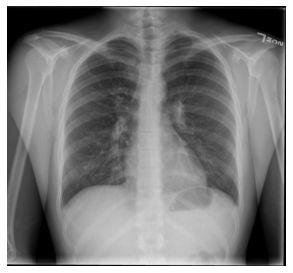

In [39]:
def demo():
    row_number = random.randint(1308, len(data) - 1)
    image = Image.open(data.iloc[row_number].image_path)
    original = data.iloc[row_number].caption
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(image)
    generated = image_captioner(image)[0]['generated_text']
    fontprop = fm.FontProperties(fname='Roboto-Regular.ttf', size=12)

#     ax.text(8, 1, impression, fontproperties=fontprop)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([]) 
    return original, generated

original, generated = demo()
print(f'(ORIGINAL)\n\n{original}')
print('============================')
print(f'\n(GENERATED)\n\n{generated}')